# 数据采样

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/br_base/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/br_base/tutorials/zh_cn/dataset/mindspore_sampler.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/br_base/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/br_base/tutorials/zh_cn/dataset/mindspore_sampler.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/br_base/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/br_base/tutorials/source_zh_cn/dataset/sampler.ipynb)

为满足训练需求，解决诸如数据集过大或样本类别分布不均等问题，MindSpore提供了多种不同用途的采样器（Sampler），帮助用户对数据集进行不同形式的采样。用户只需在加载数据集时传入采样器对象，即可实现数据的采样。

MindSpore目前提供了如`RandomSampler`、`WeightedRandomSampler`、`SubsetRandomSampler`等多种采样器。此外，用户也可以根据需要实现自定义的采样器类。

> 更多采样器的使用方法参见[采样器API文档](https://www.mindspore.cn/docs/zh-CN/br_base/api_python/mindspore.dataset.loading.html#%E9%87%87%E6%A0%B7%E5%99%A8-1)。

## 采样器

下面主要以CIFAR-10数据集为例，介绍几种常用MindSpore采样器的使用方法。

![cifar10](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/br_base/tutorials/source_zh_cn/dataset/images/cifar10.jpg)

> 本章节中的示例代码依赖`matplotlib`，可使用命令`pip install matplotlib`安装。如本文档以Notebook运行时，完成安装后需要重启kernel才能执行后续代码。

In [1]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"

path = download(url, "./", kind="tar.gz", replace=True)


file_sizes: 100%|████████████████████████████| 170M/170M [00:16<00:00, 10.4MB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to ./


解压后数据集文件的目录结构如下：

```text
.
└── cifar-10-batches-bin
    ├── batches.meta.txt
    ├── data_batch_1.bin
    ├── data_batch_2.bin
    ├── data_batch_3.bin
    ├── data_batch_4.bin
    ├── data_batch_5.bin
    ├── readme.html
    └── test_batch.bin
```

### RandomSampler

从索引序列中随机采样指定数目的数据。

下面的样例使用随机采样器，分别从数据集中有放回和无放回地随机采样5个数据，并打印展示。为了便于观察有放回与无放回的效果，这里自定义了一个数据量较小的数据集。

In [2]:
from mindspore.dataset import RandomSampler, NumpySlicesDataset

np_data = [1, 2, 3, 4, 5, 6, 7, 8]  # 数据集

# 定义有放回采样器，采样5条数据
sampler1 = RandomSampler(replacement=True, num_samples=5)
dataset1 = NumpySlicesDataset(np_data, column_names=["data"], sampler=sampler1)

print("With Replacement:    ", end='')
for data in dataset1.create_tuple_iterator(output_numpy=True):
    print(data[0], end=' ')

# 定义无放回采样器，采样5条数据
sampler2 = RandomSampler(replacement=False, num_samples=5)
dataset2 = NumpySlicesDataset(np_data, column_names=["data"], sampler=sampler2)

print("\nWithout Replacement: ", end='')
for data in dataset2.create_tuple_iterator(output_numpy=True):
    print(data[0], end=' ')

With Replacement:    4 5 6 6 1 
Without Replacement: 4 1 5 6 2 

从上面的打印结果可以看出，使用有放回采样器时，同一条数据可能会被多次获取；使用无放回采样器时，同一条数据只能被获取一次。

### WeightedRandomSampler

指定长度为N的采样概率列表，按照概率在前N个样本中随机采样指定数目的数据。

下面的样例使用带权随机采样器从CIFAR-10数据集的前10个样本中按概率获取6个样本，并展示已读取数据的形状和标签。

Image shape: (32, 32, 3) , Label: 6
Image shape: (32, 32, 3) , Label: 6
Image shape: (32, 32, 3) , Label: 9
Image shape: (32, 32, 3) , Label: 9
Image shape: (32, 32, 3) , Label: 9
Image shape: (32, 32, 3) , Label: 6


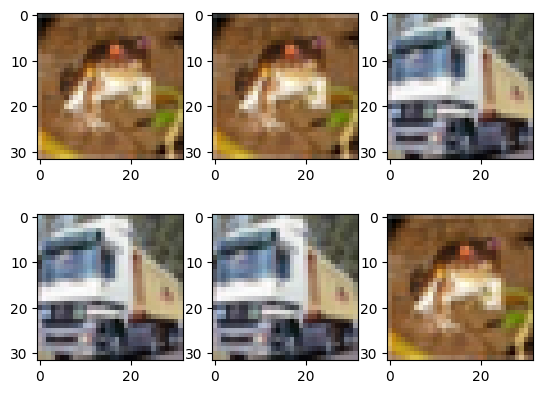

In [3]:
import math
import matplotlib.pyplot as plt
from mindspore.dataset import WeightedRandomSampler, Cifar10Dataset
%matplotlib inline

DATA_DIR = "./cifar-10-batches-bin/"

# 指定前10个样本的采样概率并进行采样
weights = [0.8, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
sampler = WeightedRandomSampler(weights, num_samples=6)
dataset = Cifar10Dataset(DATA_DIR, sampler=sampler)  # 加载数据

def plt_result(dataset, row):
    """显示采样结果"""
    num = 1
    for data in dataset.create_dict_iterator(output_numpy=True):
        print("Image shape:", data['image'].shape, ", Label:", data['label'])
        plt.subplot(row, math.ceil(dataset.get_dataset_size() / row), num)
        image = data['image']
        plt.imshow(image, interpolation="None")
        num += 1

plt_result(dataset, 2)

从上面的打印结果可以看出，本次在10个样本中随机采样了6条数据，只有前面两个采样概率不为0的样本才有机会被采样。

### SubsetRandomSampler

从指定样本索引子序列中随机采样指定数目的样本数据。

下面的样例使用子序列随机采样器从CIFAR-10数据集的指定子序列中抽样6个样本，并展示已读取数据的形状和标签。

Image shape: (32, 32, 3) , Label: 9
Image shape: (32, 32, 3) , Label: 1
Image shape: (32, 32, 3) , Label: 4
Image shape: (32, 32, 3) , Label: 9
Image shape: (32, 32, 3) , Label: 6
Image shape: (32, 32, 3) , Label: 1


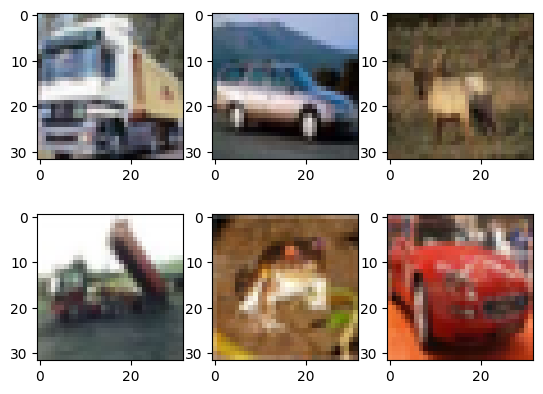

In [4]:
from mindspore.dataset import SubsetRandomSampler

# 指定样本索引序列
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
sampler = SubsetRandomSampler(indices, num_samples=6)
# 加载数据
dataset = Cifar10Dataset(DATA_DIR, sampler=sampler)

plt_result(dataset, 2)

从上面的打印结果可以看到，采样器从索引序列中随机采样了6个样本。

### PKSampler

在指定的数据集类别P中，每种类别各采样K条数据。

下面的样例使用PK采样器从CIFAR-10数据集中每种类别抽样2个样本，最多10个样本，并展示已读取数据的形状和标签。

Image shape: (32, 32, 3) , Label: 0
Image shape: (32, 32, 3) , Label: 0
Image shape: (32, 32, 3) , Label: 1
Image shape: (32, 32, 3) , Label: 1
Image shape: (32, 32, 3) , Label: 2
Image shape: (32, 32, 3) , Label: 2
Image shape: (32, 32, 3) , Label: 3
Image shape: (32, 32, 3) , Label: 3
Image shape: (32, 32, 3) , Label: 4
Image shape: (32, 32, 3) , Label: 4


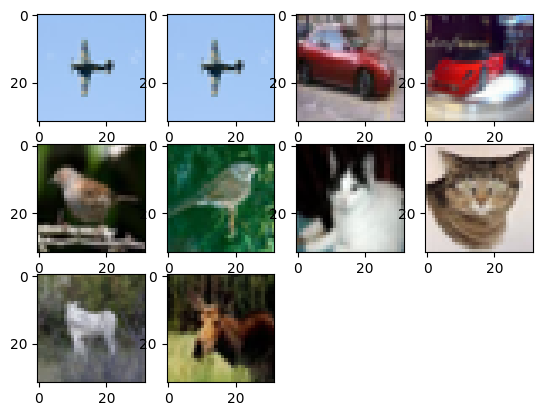

In [5]:
from mindspore.dataset import PKSampler

# 每种类别抽样2个样本，最多10个样本
sampler = PKSampler(num_val=2, class_column='label', num_samples=10)
dataset = Cifar10Dataset(DATA_DIR, sampler=sampler)

plt_result(dataset, 3)

从上面的打印结果可以看出，采样器对数据集中的每种标签都采样了2个样本，一共10个样本。

### DistributedSampler

在分布式训练中，对数据集分片进行采样。

下面的样例展示了一个有12个样本的数据集，并使用分布式采样器将数据集划分为4个分片，每个分片的采样规则如下：

| shard id |  sample id  |
| -------- | ----------- |
| shard 0  |  0, 4, 8    |
| shard 1  |  1, 5, 9    |
| shard 2  |  2, 6, 10   |
| shard 3  |  3, 7, 11   |

每个分片都具有3个样本，下面展示读取分片0中的包含的采样数据。

In [6]:
from mindspore.dataset import DistributedSampler

# 自定义数据集
data_source = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# 构建的数据集分为4片，共采样3个数据样本
sampler = DistributedSampler(num_shards=4, shard_id=0, shuffle=False)
dataset = NumpySlicesDataset(data_source, column_names=["data"], sampler=sampler)

# 打印数据集
for data in dataset.create_dict_iterator():
    print(data)

{'data': Tensor(shape=[], dtype=Int64, value= 0)}
{'data': Tensor(shape=[], dtype=Int64, value= 4)}
{'data': Tensor(shape=[], dtype=Int64, value= 8)}


从上面的打印结果可以看出，数据集被分成了4片，每片有3个样本，本次获取的是id为0的片中的样本。

## 自定义采样器

用户可以自定义采样器，并把它应用到数据集上。

### \_\_iter\_\_ 模式

用户可以继承`Sampler`基类，通过实现`__iter__`方法来自定义采样器的采样方式。

下面的样例定义了一个从下标0至下标9间隔为2采样的采样器，将其作用于自定义数据集，并展示已读取数据。

In [7]:
import mindspore.dataset as ds

# 自定义采样器
class MySampler(ds.Sampler):
    def __iter__(self):
        for i in range(0, 10, 2):
            yield i

# 自定义数据集
np_data = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

# 加载数据
dataset = ds.NumpySlicesDataset(np_data, column_names=["data"], sampler=MySampler())
for data in dataset.create_tuple_iterator(output_numpy=True):
    print(data[0], end=' ')

a c e g i 

从上面的打印可以看出，自定义的采样器读取了下标为0、2、4、6、8的样本数据，这与自定义采样器的采样目的一致。

### \_\_getitem\_\_ 模式

用户可以定义一个采样器类，该类包含 `__init__` 、 `__getitem__` 和 `__len__` 方法。

下面的样例定义了一个下标为 `[3, 4, 3, 2, 0, 11, 5, 5, 5, 9, 1, 11, 11, 11, 11, 8]` 的采样器类，将其作用于自定义数据集，并展示已读取数据。

In [7]:
import mindspore.dataset as ds

# 自定义采样器
class MySampler():
    def __init__(self):
        self.index_ids = [3, 4, 3, 2, 0, 11, 5, 5, 5, 9, 1, 11, 11, 11, 11, 8]
    def __getitem__(self, index):
        return self.index_ids[index]
    def __len__(self):
        return len(self.index_ids)

# 自定义数据集
np_data = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

# 加载数据
dataset = ds.NumpySlicesDataset(np_data, column_names=["data"], sampler=MySampler())
for data in dataset.create_tuple_iterator(output_numpy=True):
    print(data[0], end=' ')

d e d c a l f f f j b l l l l i 

从上面的打印可以看出，自定义的采样器读取了下标为 `[3, 4, 3, 2, 0, 11, 5, 5, 5, 9, 1, 11, 11, 11, 11, 8]` 的样本数据，这与自定义采样器的采样目的一致。